Dimensionality Reduction
---
##### 14Dec2018
Using discrete (`inputs/GSM1626793_P14Retina_1.digital_expression.txt.gz`, Mocosko, _et al_ 2015) and continuous (`inputs/qi_s1_edited_all.csv.gz`) datasets, downsample and feature select, then perform various DR techniques and compare the following:
* __Euclidean cell-cell distance__ correlations before and after transformation/reduction
* __Kullback-Leibler Divergence (KLD)__ explaining the Shannon entropy of the difference between the cumulative probability distributions of unique, normalized cell-cell distances.
* __K-nearest neighbor (Knn)__ preservation

In [207]:
import sys
from fcc_DRs import *
from fcc_utils import *

In [205]:
# reload functions when editing file
del sys.modules['fcc_DRs']
from fcc_DRs import *

KeyError: 'fcc_DRs'

---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [2]:
P14Retina = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.digital_expression.txt.gz', cells_axis=1, labels=[0,0])

In [3]:
P14Retina.data.shape

(6600, 20478)

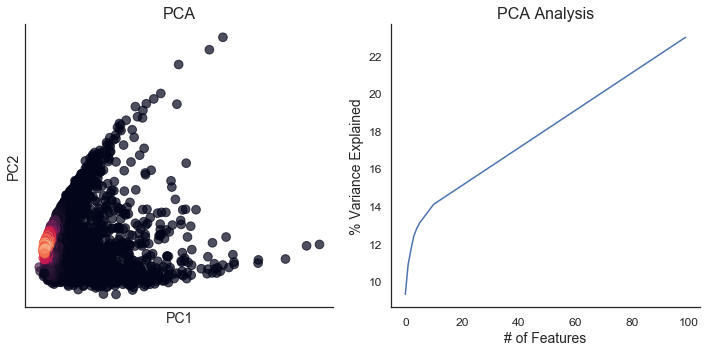

In [4]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(), n_components=100)
P14Retina_PCA100.plot()

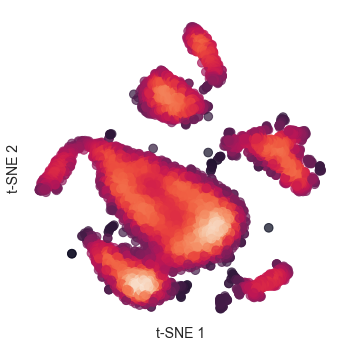

CPU times: user 55.4 s, sys: 2.6 s, total: 58 s
Wall time: 58.8 s


In [47]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1272e0e48>)

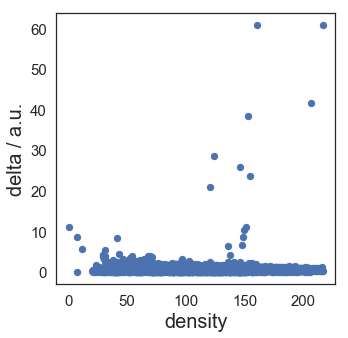

In [48]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f190a20>)

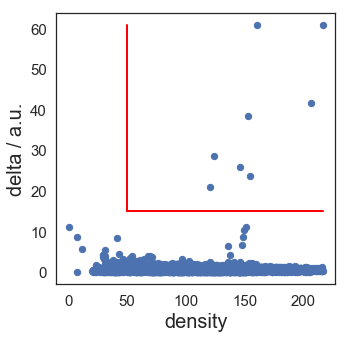

In [49]:
P14Retina_tSNE.clu.assign(50,15) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

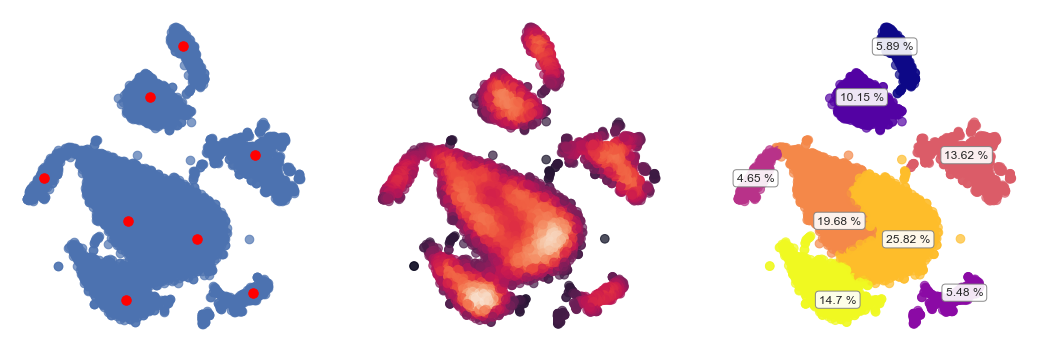

In [50]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [51]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.4713487923145294



---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [156]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [157]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

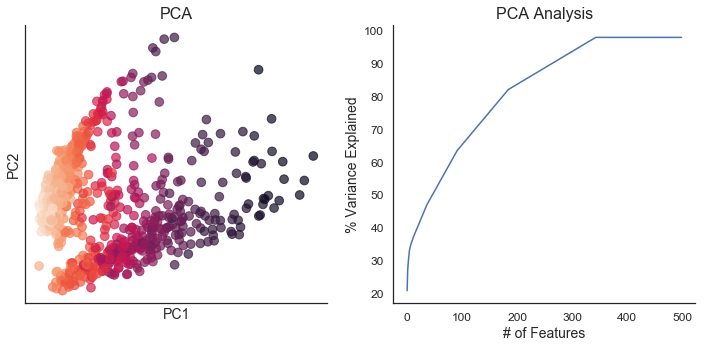

In [158]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot()

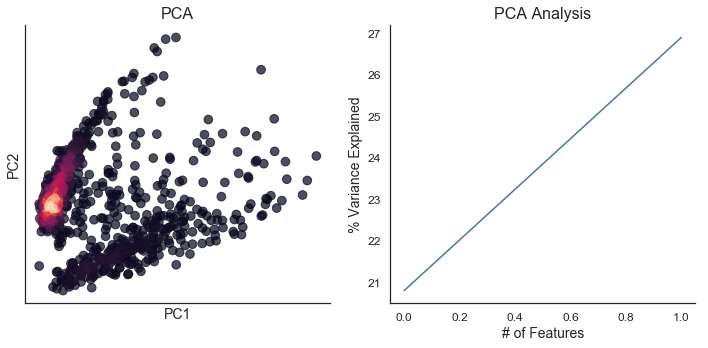

In [159]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot()

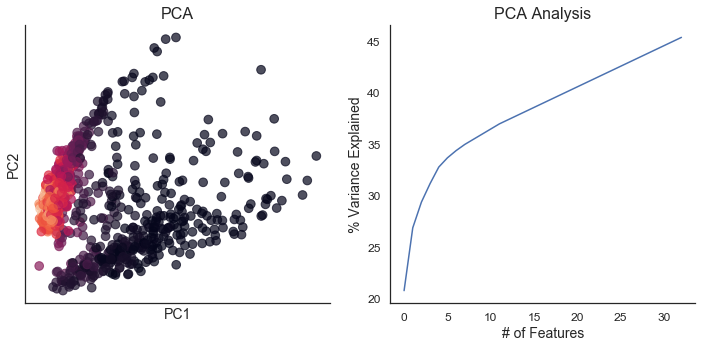

In [160]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot()

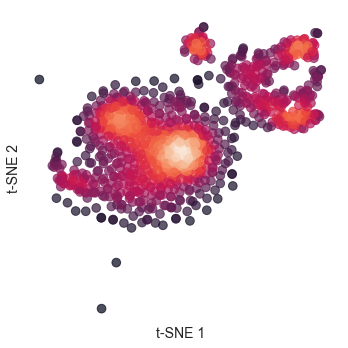

In [161]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

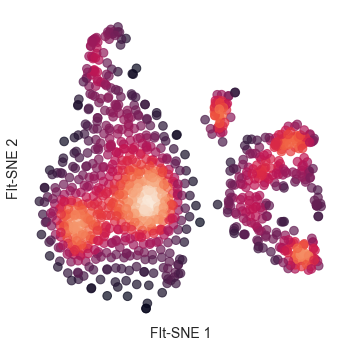

In [209]:
P14Retina_0_FItSNE = fcc_FItSNE(P14Retina_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_FItSNE.plot()

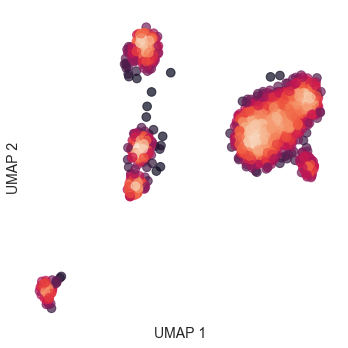

In [162]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(), perplexity=30) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [163]:
P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1003 cells.
Calculating low dimensional representations...
Calculating reconstructions...


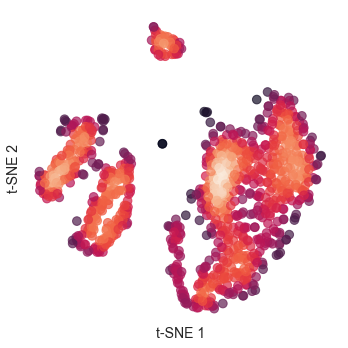

In [203]:
test = RNA_counts(data=P14Retina_0_DCA.results)
P14Retina_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_DCAtSNE.plot()

---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [149]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [164]:
k = 30 # choose value for K-nearest neighbor calculations

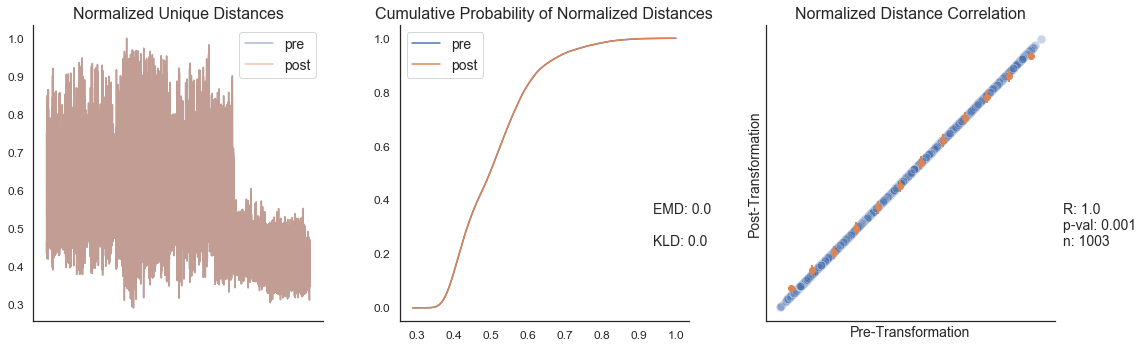

Knn Preservation: 100.0

CPU times: user 30.5 s, sys: 4.52 s, total: 35 s
Wall time: 34.4 s


In [165]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

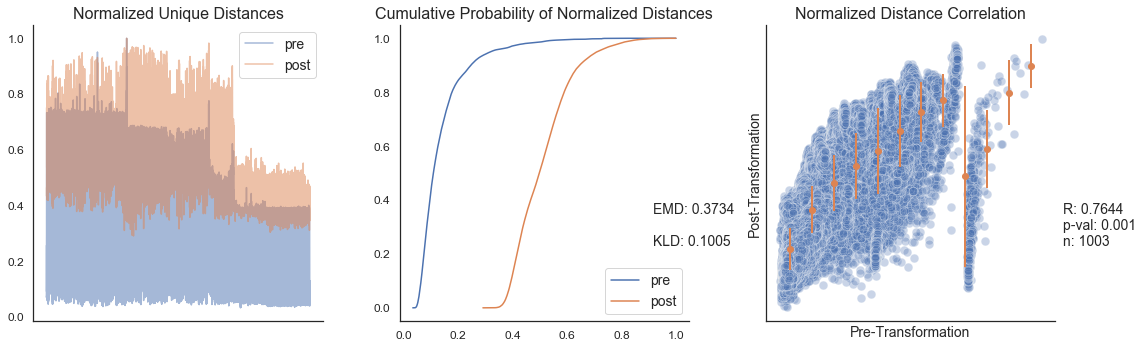

Knn Preservation: 95.5446

CPU times: user 30.1 s, sys: 4.19 s, total: 34.3 s
Wall time: 33.6 s


In [167]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000))))

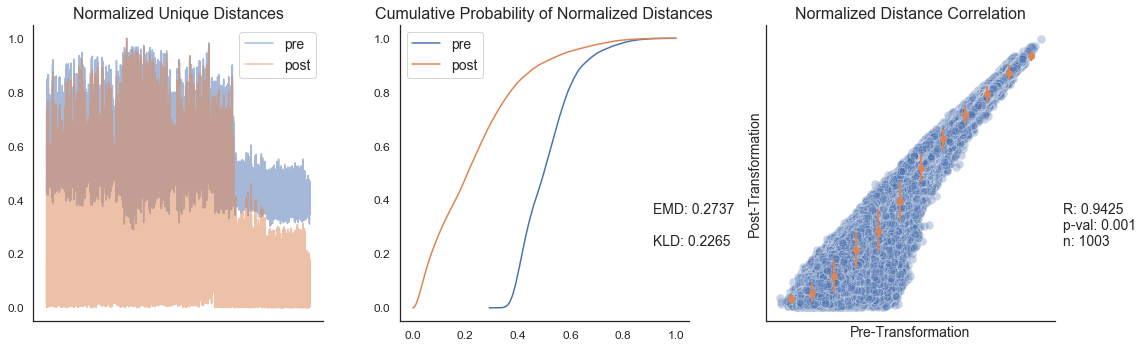

Knn Preservation: 96.9271

CPU times: user 26.6 s, sys: 3.96 s, total: 30.6 s
Wall time: 29.9 s


In [168]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

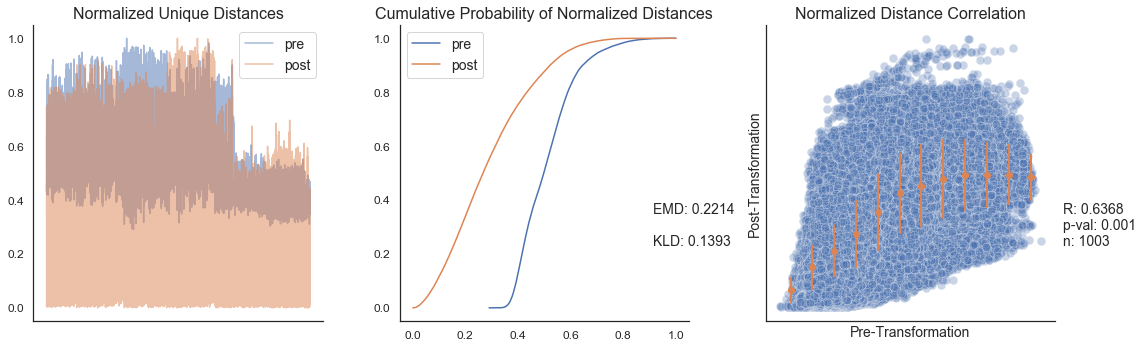

Knn Preservation: 95.7829

CPU times: user 29 s, sys: 4.25 s, total: 33.3 s
Wall time: 32.6 s


In [169]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

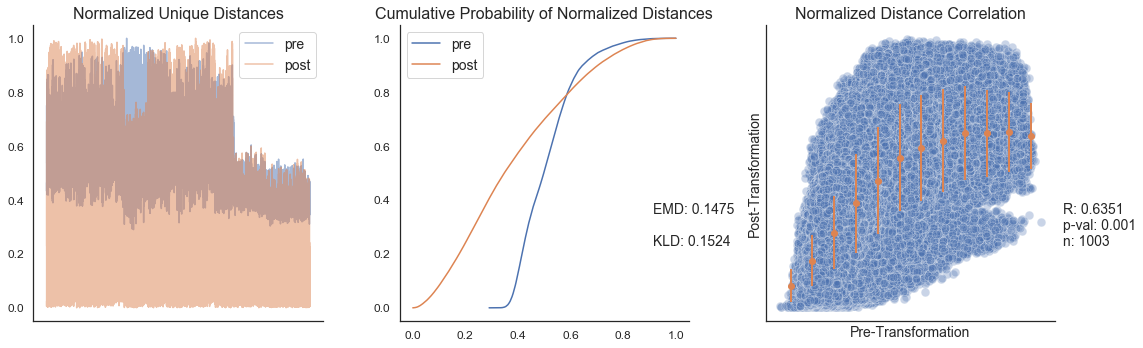

Knn Preservation: 95.8233

CPU times: user 26.8 s, sys: 4.47 s, total: 31.3 s
Wall time: 31.7 s


In [210]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_FItSNE.knn_graph(k))))

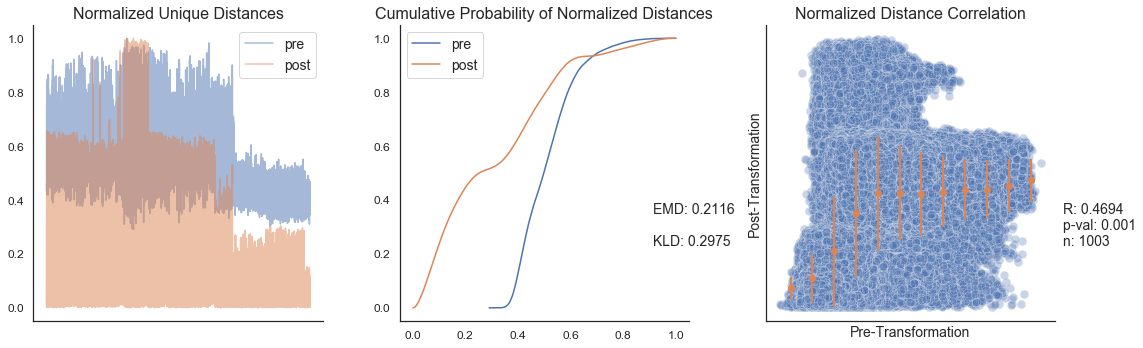

Knn Preservation: 94.9629

CPU times: user 26.8 s, sys: 4.32 s, total: 31.1 s
Wall time: 30.5 s


In [170]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

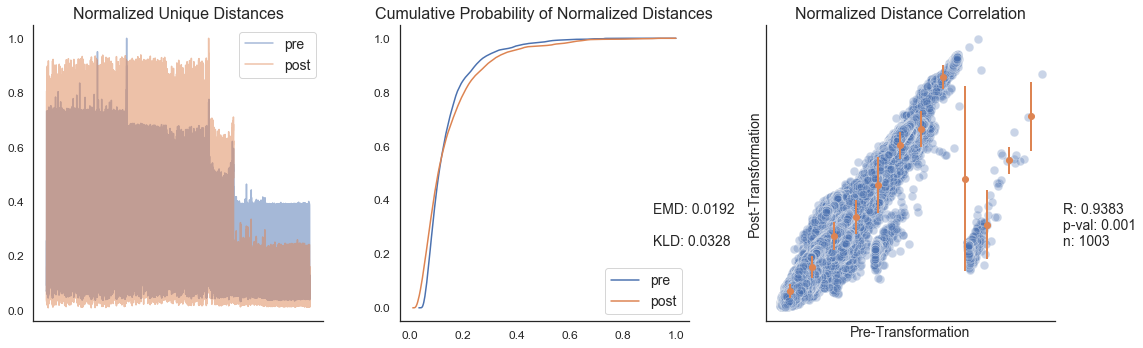

Knn Preservation: 96.573

CPU times: user 28.8 s, sys: 4.4 s, total: 33.2 s
Wall time: 32.6 s


In [171]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

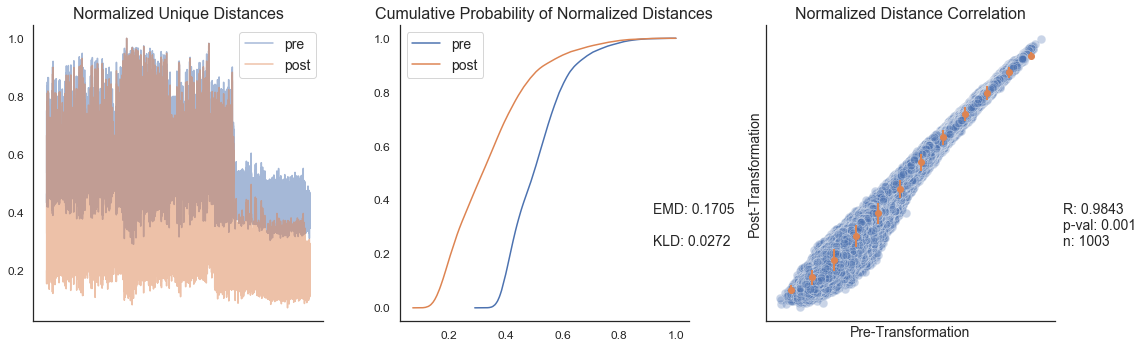

Knn Preservation: 97.974

CPU times: user 28.7 s, sys: 4.3 s, total: 33 s
Wall time: 32.3 s


In [172]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))

---
#### 3. repeat for continuous dataset

---
#### 3.0. read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [173]:
%time qi = RNA_counts.from_file('inputs/qi_s1_edited_all.csv.gz', cells_axis=0, labels=[None,None])

CPU times: user 15.2 s, sys: 876 ms, total: 16.1 s
Wall time: 16.4 s


In [174]:
qi.data.shape

(1595, 25507)

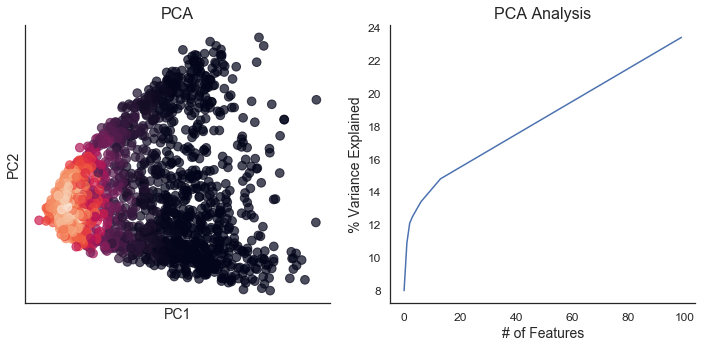

In [181]:
qi_PCA100 = fcc_PCA(qi.arcsinh_norm(), n_components=100)
qi_PCA100.plot()

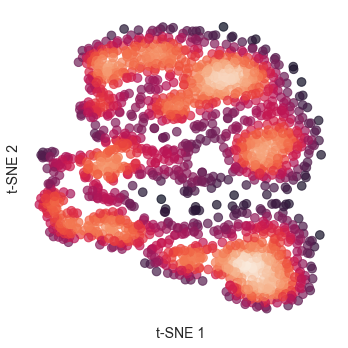

CPU times: user 11.1 s, sys: 321 ms, total: 11.4 s
Wall time: 11.2 s


In [182]:
%%time 
qi_tSNE = fcc_tSNE(qi_PCA100.results, perplexity=30) # use standard perplexity of 30 here
qi_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12cd05198>)

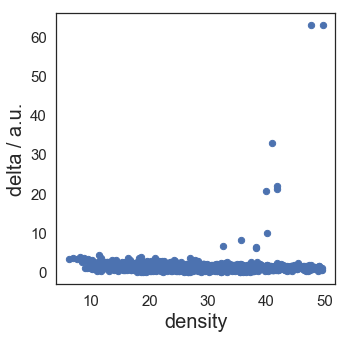

In [183]:
qi_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c9332b0>)

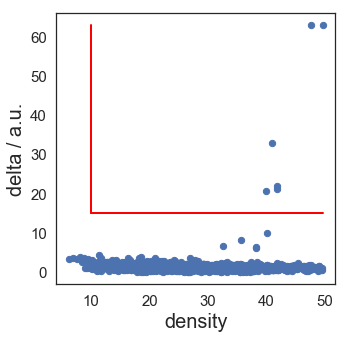

In [184]:
qi_tSNE.clu.assign(10,15) # assign cluster center cutoffs
qi_tSNE.clu.draw_decision_graph(min_delta=qi_tSNE.clu.min_delta, min_density=qi_tSNE.clu.min_density) # plot chosen density-peak cluster centers

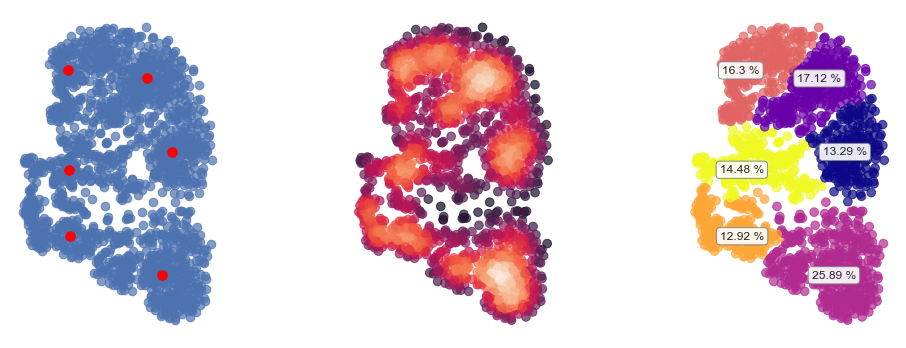

In [185]:
qi_tSNE.plot_clusters() # visualize clustering

In [186]:
print('Silhouette Score: {}\n'.format(qi_tSNE.silhouette_score()))
qi_tSNE.cluster_counts()

Silhouette Score: 0.4206560552120209

212 cells in cluster 0 (13.292 %)

273 cells in cluster 1 (17.116 %)

413 cells in cluster 2 (25.893 %)

260 cells in cluster 3 (16.301 %)

206 cells in cluster 4 (12.915 %)

231 cells in cluster 5 (14.483 %)



---
#### 3.1. feature-select continuous dataset and perform DRs
* select _500 most variable genes_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [187]:
# select 500 most variable genes
qi_0 = RNA_counts.var_select(qi, n_features=500) 

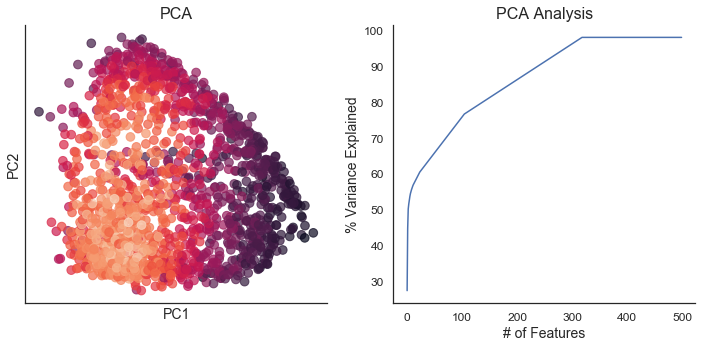

In [188]:
qi_0_PCA500 = fcc_PCA(qi_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
qi_0_PCA500.plot()

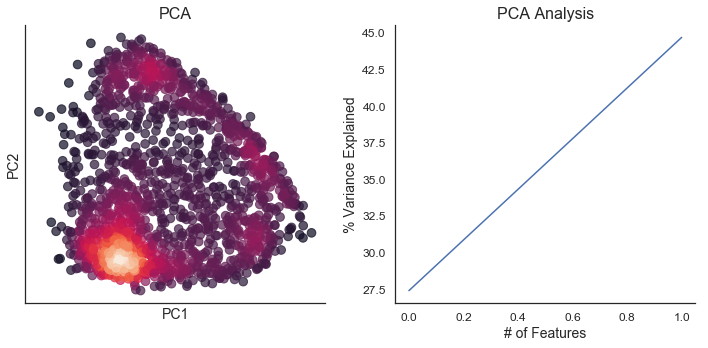

In [189]:
qi_0_PCA2 = fcc_PCA(qi_0.arcsinh_norm(), n_components=2) # 2 component PCA
qi_0_PCA2.plot()

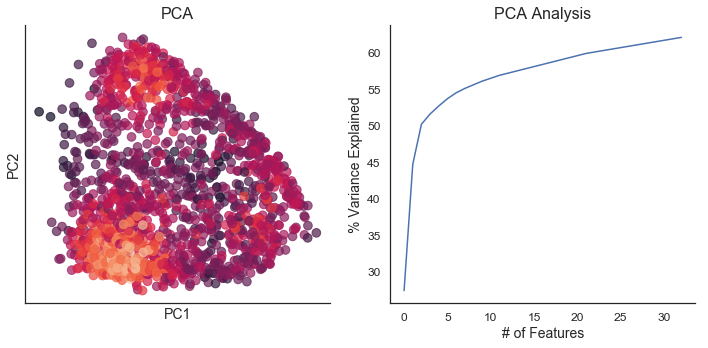

In [190]:
qi_0_PCA33 = fcc_PCA(qi_0.arcsinh_norm(), n_components=33) # 33 component PCA to compare to DCA
qi_0_PCA33.plot()

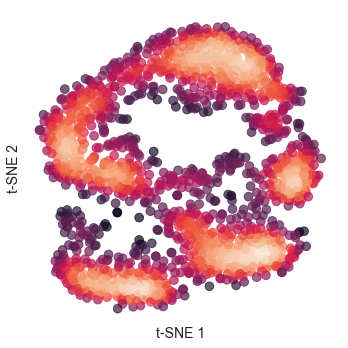

In [191]:
qi_0_tSNE = fcc_tSNE(qi_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
qi_0_tSNE.plot()

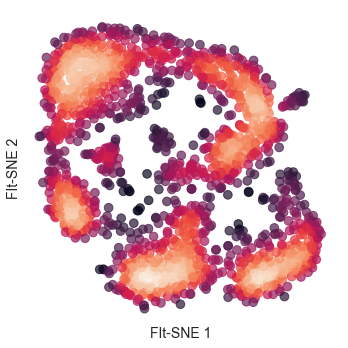

In [211]:
qi_0_FItSNE = fcc_FItSNE(qi_0.arcsinh_norm(), perplexity=30) # FIt-SNE with perplexity 30
qi_0_FItSNE.plot()

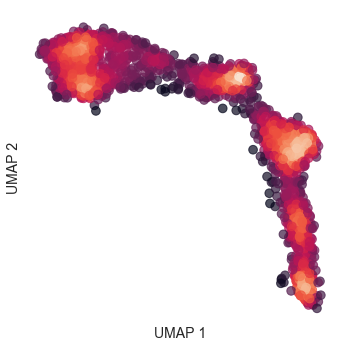

In [192]:
qi_0_UMAP = fcc_UMAP(qi_0.arcsinh_norm(), perplexity=30) # UMAP with perplexity 30
qi_0_UMAP.plot()

In [193]:
qi_0_DCA = fcc_DCA(qi_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1595 cells.
Calculating low dimensional representations...
Calculating reconstructions...


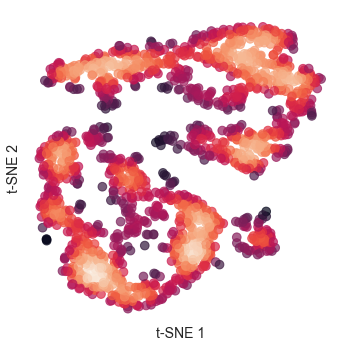

In [202]:
test = RNA_counts(data=qi_0_DCA.results)
qi_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
qi_0_DCAtSNE.plot()

---
#### 3.2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

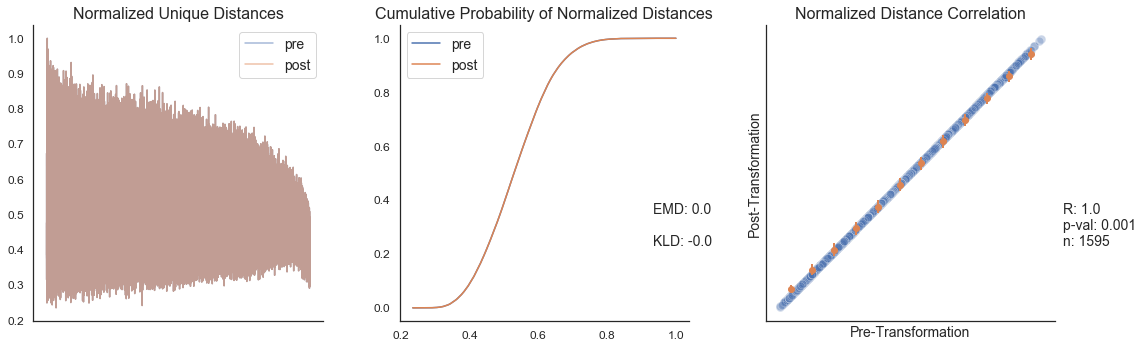

Knn Preservation: 100.0

CPU times: user 1min 28s, sys: 12.9 s, total: 1min 41s
Wall time: 1min 41s


In [194]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA500.knn_graph(k))))

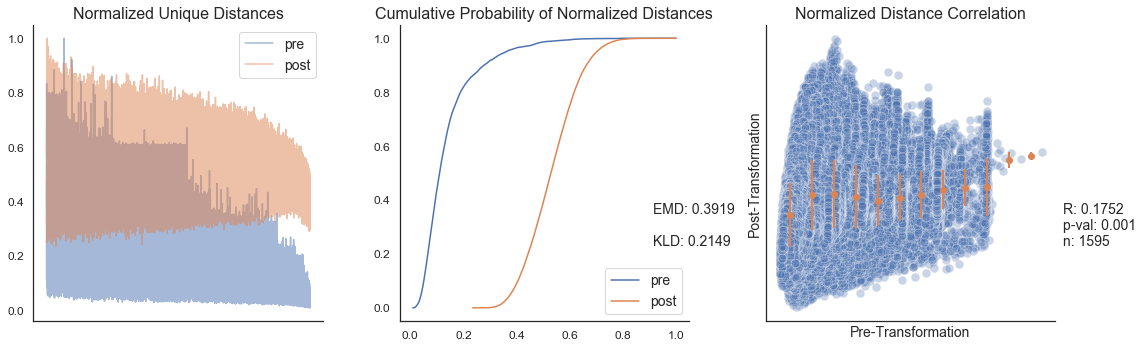

Knn Preservation: 97.1573

CPU times: user 1min 34s, sys: 16.5 s, total: 1min 50s
Wall time: 1min 52s


In [195]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0.knn_graph(k, transform='arcsinh', scale=1000))))

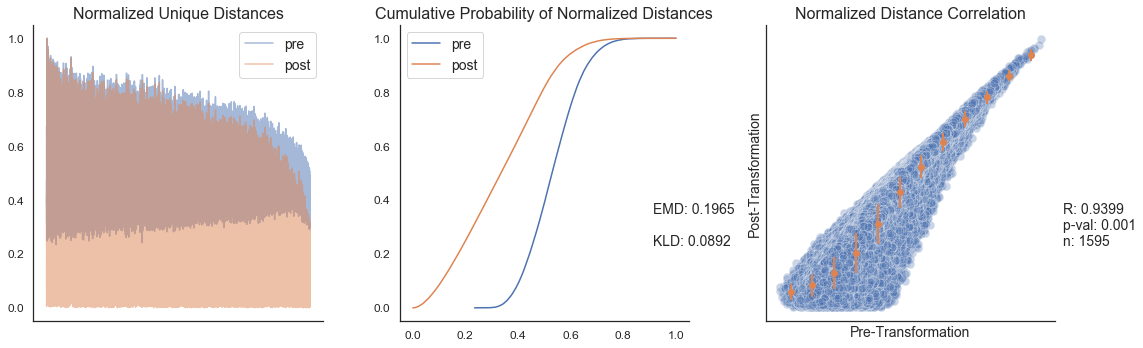

Knn Preservation: 98.6186

CPU times: user 1min 21s, sys: 11.8 s, total: 1min 33s
Wall time: 1min 33s


In [196]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA2.knn_graph(k))))

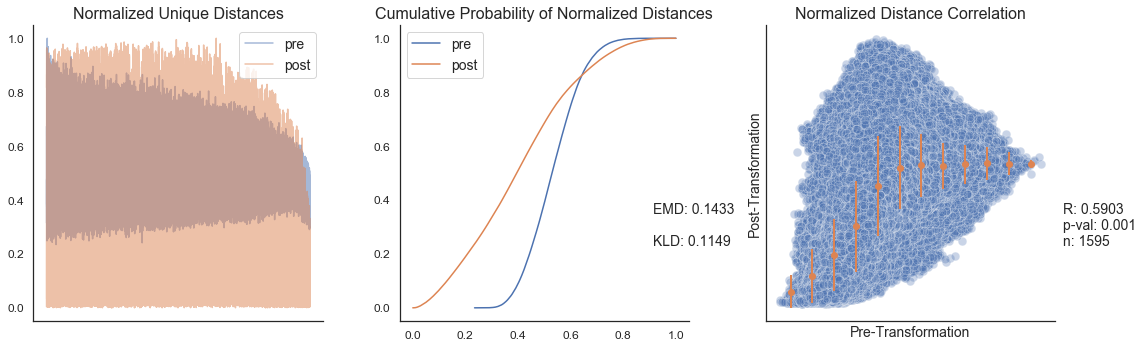

Knn Preservation: 97.9271

CPU times: user 1min 26s, sys: 11.1 s, total: 1min 37s
Wall time: 1min 39s


In [197]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_tSNE.knn_graph(k))))

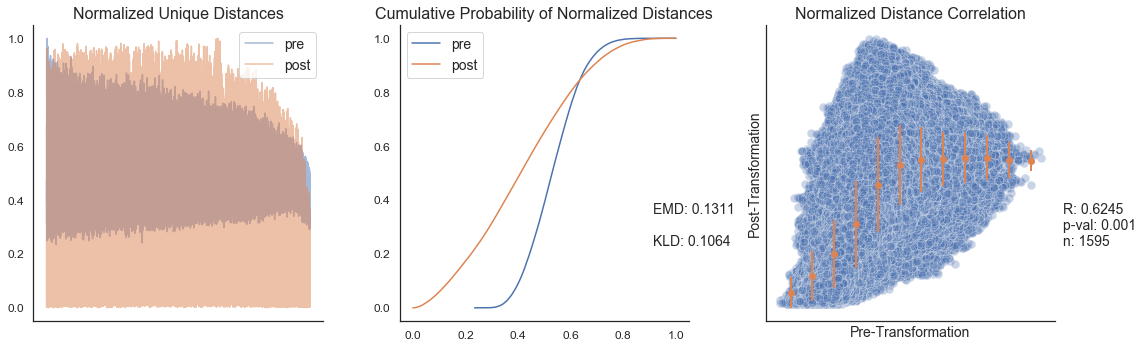

Knn Preservation: 97.9719

CPU times: user 1min 24s, sys: 10.9 s, total: 1min 34s
Wall time: 1min 34s


In [212]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_FItSNE.knn_graph(k))))

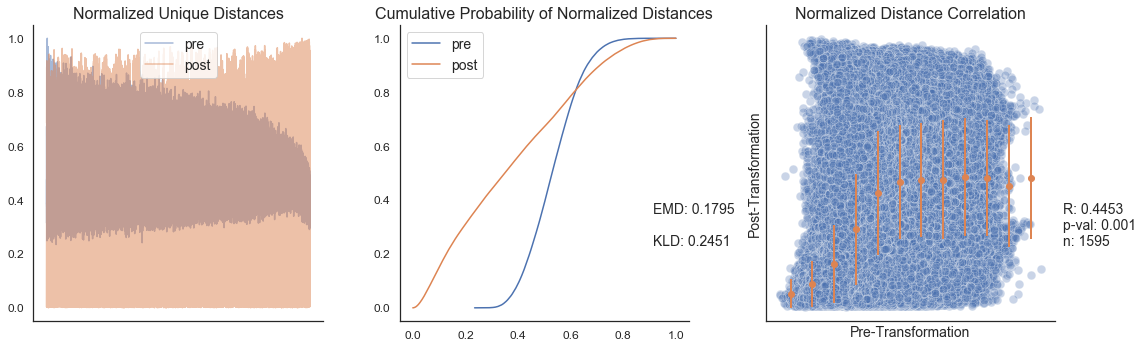

Knn Preservation: 96.8338

CPU times: user 1min 25s, sys: 11.5 s, total: 1min 36s
Wall time: 1min 36s


In [198]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_UMAP.knn_graph(k))))

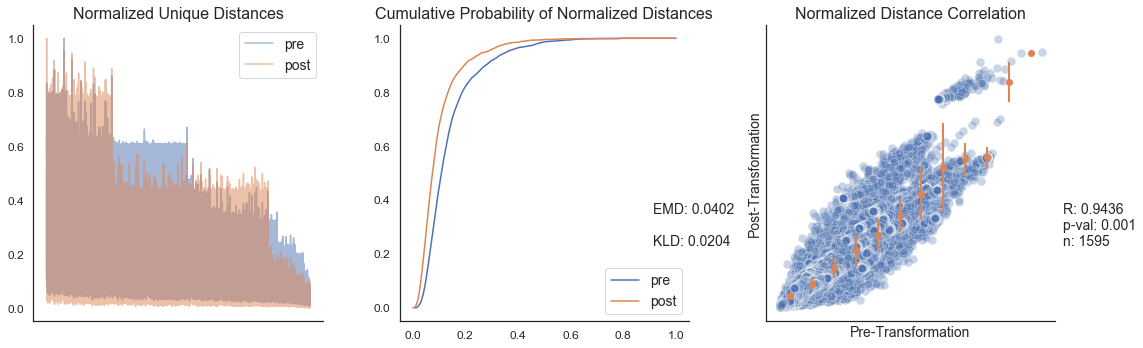

Knn Preservation: 98.1951

CPU times: user 1min 25s, sys: 12.4 s, total: 1min 37s
Wall time: 1min 37s


In [199]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0_DCA.knn_graph(k))))

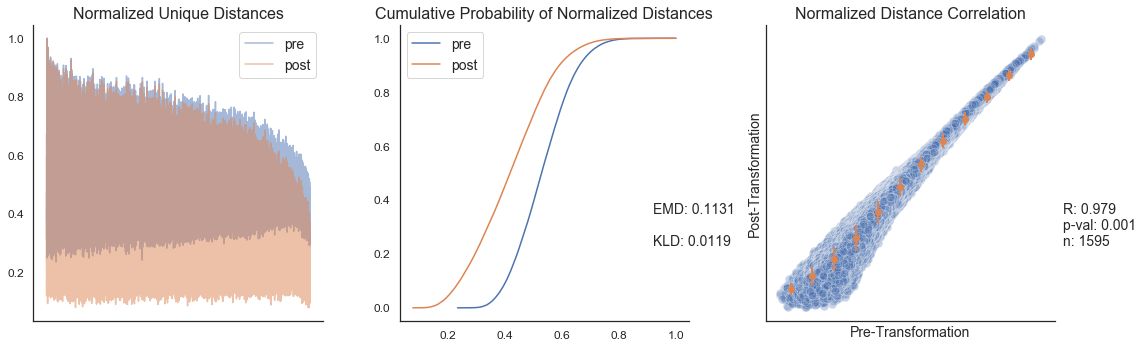

Knn Preservation: 99.5822

CPU times: user 1min 21s, sys: 11.1 s, total: 1min 32s
Wall time: 1min 33s


In [200]:
%%time
# look at 33-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA33.knn_graph(k))))